# Feature Selection & Engineering 

Julian Law

In [1]:
import os
import sys
sys.path.append('../')
import glob2 as glob
import json
import requests
import joblib
import pickle as pkl
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [38]:
# Sklearn stuff
SEED = 17

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, KFold

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
#PATH_TO_DATA = '../input/'


# Import Training and Test Data  
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [73]:
train_features.columns.index

AttributeError: 'Index' object has no attribute 'index'

In [21]:
# Combining training and test features for convenience so I can hot encode both at same time
all_features = pd.concat([train_features, test_features])
all_targets = pd.concat([train_targets, test_targets])

all_merged = pd.concat([all_targets, all_features], axis=1)

# Index to split the training and test data sets
idx_split = train_features.shape[0]

In [22]:
all_merged.head()

,radiant_win,duration,1is_pick,1team,1hero_id,2is_pick,2team,2hero_id,3is_pick,3team,3hero_id,4is_pick,4team,4hero_id,5is_pick,5team,5hero_id,6is_pick,6team,6hero_id,7is_pick,7team,7hero_id,8is_pick,8team,8hero_id,9is_pick,9team,9hero_id,10is_pick,10team,10hero_id,11is_pick,11team,11hero_id,12is_pick,12team,12hero_id,13is_pick,13team,13hero_id,14is_pick,14team,14hero_id,15is_pick,15team,15hero_id,16is_pick,16team,16hero_id,17is_pick,17team,17hero_id,18is_pick,18team,18hero_id,19is_pick,19team,19hero_id,20is_pick,20team,20hero_id,21is_pick,21team,21hero_id,22is_pick,22team,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,1,2069,0,0,25,0,1,66,0,0,60,0,1,90,0,0,7,0,1,96,1,0,85,1,1,102,1,1,6,1,0,52,0,0,13,0,1,19,0,0,46,0,1,98,1,1,86,1,0,20,1,1,72,1,0,77,0,1,23,0,0,112,1,0,129,1,1,2
4865407245,0,2524,0,1,71,0,0,18,0,1,55,0,0,66,0,1,129,0,0,96,1,1,37,1,0,121,1,0,103,1,1,100,0,1,106,0,0,104,0,1,16,0,0,76,1,0,65,1,1,8,1,0,46,1,1,57,0,0,114,0,1,10,1,1,17,1,0,42
4889341660,0,2151,0,1,105,0,0,107,0,1,121,0,0,80,0,1,86,0,0,66,1,1,57,1,0,18,1,0,111,1,1,95,0,1,96,0,0,11,0,1,55,0,0,52,1,0,79,1,1,27,1,0,2,1,1,85,0,0,17,0,1,35,1,1,76,1,0,43
5050335216,1,2484,0,0,84,0,1,90,0,0,19,0,1,79,0,0,60,0,1,23,1,0,103,1,1,96,1,1,86,1,0,106,0,0,61,0,1,10,0,0,93,0,1,41,1,1,37,1,0,9,1,1,72,1,0,76,0,1,16,0,0,39,1,0,108,1,1,59
4860032461,1,1958,0,1,111,0,0,18,0,1,69,0,0,55,0,1,65,0,0,8,1,1,66,1,0,121,1,0,16,1,1,107,0,1,42,0,0,46,0,1,10,0,0,54,1,0,37,1,1,96,1,0,106,1,1,76,0,0,95,0,1,82,1,1,1,1,0,73


Let's play around with only hero_id columns

In [34]:
# Quick check that hero ids are unique (i.e., no double picking)
# https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch

np.all(all_features[[f'{i}hero_id' for i in range(1, 23)]].nunique(axis=1) == 22)

True

In [23]:
heroes_df = all_features[[f'{i}hero_id' for i in range(1, 23)]]
#df_full_features1 = df_full_features.copy()
heroes_df1 = heroes_df.copy()

In [26]:
np.sort(np.unique(heroes_df[[f'{i}hero_id' for i in range(1, 23)]].values.flatten()))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 119, 120, 121, 129],
      dtype=int64)

In [30]:
(unique, counts) = np.unique(heroes_df[[f'{i}hero_id' for i in range(1, 23)]],return_counts=True) 
frequencies = np.asarray((unique, counts)).T
frequencies.T
#print(frequencies.T)

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 119, 120, 121, 129],
       [116, 239, 128, 156, 221,  63, 302, 336, 550, 466,  66,  64, 153,
         29, 165, 398, 262, 339, 484,  22,  58, 108, 715, 507,  58, 202,
         51, 209,  55, 119,  14, 304,  35,  82,  55, 266, 266, 162,  53,
        554, 313, 260,  58, 139, 351,  63,  12,  68,  85,  56, 613,  65,
        460, 228,  12, 484, 277,  70, 382, 196,  3

In [32]:
heroes_df_ohe = heroes_df.copy()
for i in range(1, 23):
    heroes_df_ohe = pd.get_dummies(heroes_df_ohe, columns = [f'{i}hero_id'])
        
heroes_df_ohe.head()

X_heroes_remain = heroes_df_ohe[:idx_split] # features set is only picks + dummies
X_heroes_test  = heroes_df_ohe[idx_split:]

In [33]:
print(f'Number of features: {heroes_df_ohe.shape[1]}')

Number of features: 2044


In [36]:
train_target = train_targets['radiant_win']

In [37]:
heroes_df_ohe.corrwith(train_target).abs().sort_values(ascending=False).head(22)

9hero_id_66      0.095098
18hero_id_89     0.085811
11hero_id_17     0.082333
12hero_id_106    0.082084
3hero_id_65      0.080910
1hero_id_76      0.080641
17hero_id_21     0.077535
10hero_id_69     0.077535
11hero_id_94     0.077535
1hero_id_68      0.076065
17hero_id_57     0.075444
22hero_id_94     0.074777
8hero_id_74      0.074480
18hero_id_44     0.074381
9hero_id_8       0.073593
19hero_id_107    0.070745
16hero_id_97     0.070745
3hero_id_119     0.070634
11hero_id_96     0.069996
21hero_id_16     0.069619
4hero_id_80      0.067958
14hero_id_77     0.067958
dtype: float64

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_heroes_remain, train_target, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [42]:
logit1 = LogisticRegression(random_state=SEED, n_jobs=-1)

In [43]:
%%time
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit1.predict_proba(X_valid)

print(f"Accuracy Score on Train Set: {logit1.score(X_train, y_train)}")
print(f"Accuracy Score on validation Set: {logit1.score(X_valid, y_valid)}")
print(f'Logit model validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.9968085106382979
Accuracy Score on validation Set: 0.44761904761904764
Logit model validation roc_auc score: 0.44934640522875813
Wall time: 2.3 s


Hmmmmm that's underwhelming...

In [46]:
#from sklearn.linear_model import LogisticRegression

validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logit = LogisticRegression(C = c,random_state=SEED)
    logit.fit(X_train,y_train)
    
    # train on traning set
    train_scores.append(logit.score(X_train,y_train))
    # score on validation set
    validation_scores.append(logit.score(X_valid,y_valid))

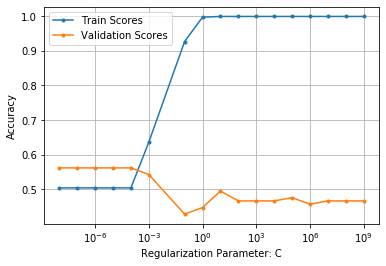

In [47]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')
plt.grid()
plt.show();

In [49]:
tuned_parameters = {'C':[.00000001,.0000001,.000001,.00001,.0001,.001,.01, .1,\
                          1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000],
                     'penalty': ['l1', 'l2']}

clf = GridSearchCV(logit, tuned_parameters, cv = 5)
search = clf.fit(X_train, y_train)
search.best_params_

{'C': 1e-08, 'penalty': 'l2'}

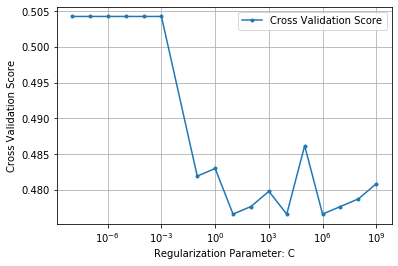

The best model has C =  1e-08
Wall time: 6.17 s


In [56]:
%%time
#Store the results
cross_validation_scores = []

C = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])


#Do some cross validation
for c in C:
    logit = LogisticRegression(C=c,random_state=SEED, solver = 'lbfgs')
    
    #the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(logit, X_train, y_train, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

## Let's make some variables 

Recall that there are a total of 22 hero selections made in pro dota during the draft and of these 22 selections there are a total of 12 hero bans and 10 hero picks. 

For reference: {B: ban, P: pick}
- 1-6 B1
- 7-10 P1
- 11-14 B2
- 15-18 P2
- 19-20 B3
- 21-22 P3,

where the index pick/ban index refers to the phases of the draft, i.e., first, second, and third phase. 

In [ ]:
col2 = [f'{i}hero_id' for i in range(1, 23)]
print(col2)

In [24]:
is_pick_col = list(f'{i}is_pick' for i in range(1, 23))
print(is_pick_col)

['1is_pick', '2is_pick', '3is_pick', '4is_pick', '5is_pick', '6is_pick', '7is_pick', '8is_pick', '9is_pick', '10is_pick', '11is_pick', '12is_pick', '13is_pick', '14is_pick', '15is_pick', '16is_pick', '17is_pick', '18is_pick', '19is_pick', '20is_pick', '21is_pick', '22is_pick']


In [26]:
# Ban columns: [i]is_pick columns to replace with 0 
# 1-6, 11-14, 19-20
ban_cols = ['1is_pick', '2is_pick', '3is_pick', '4is_pick', '5is_pick', '6is_pick', '11is_pick', '12is_pick', '13is_pick', '14is_pick', '19is_pick', '20is_pick']

In [62]:
ban_cols = {
    '1is_pick': 0, 
     '2is_pick': 0, 
     '3is_pick': 0, 
     '4is_pick': 0, 
     '5is_pick': 0, 
     '6is_pick': 0, 
     '11is_pick': 0, 
     '12is_pick': 0, 
     '13is_pick': 0, 
     '14is_pick': 0, 
     '19is_pick': 0, 
     '20is_pick': 0
}

In [67]:
df[['1is_pick', '2is_pick', '3is_pick', '4is_pick', '5is_pick', '6is_pick', '11is_pick', '12is_pick', '13is_pick', '14is_pick', '19is_pick', '20is_pick']] = 0

In [ ]:
data[[
'1team', '1hero_id',
'2team', '2hero_id', 
'3team', '3hero_id', 
'4team', '4hero_id', 
'5team', '5hero_id', 
'6team', '6hero_id', 
'7team', '7hero_id', 
'8team', '8hero_id', 
'9team', '9hero_id', 
'10team', '10hero_id', 
'11team', '11hero_id', 
'12team', '12hero_id',
'13team', '13hero_id', 
'14team', '14hero_id', 
'15team', '15hero_id', 
'16team', '16hero_id', 
'17team', '17hero_id',
'18team', '18hero_id', 
'19team', '19hero_id',
'20team', '20hero_id',
'21team', '21hero_id', 
'22team', '22hero_id'
]]

In [69]:
hero_id_col = data[[
    '1hero_id', 
    '2hero_id', 
    '3hero_id', 
    '4hero_id', 
    '5hero_id', 
    '6hero_id', 
    '7hero_id', 
    '8hero_id', 
    '9hero_id',
    '10hero_id',
    '11hero_id', 
    '12hero_id', 
    '13hero_id', 
    '14hero_id', 
    '15hero_id', 
    '16hero_id', 
    '17hero_id', 
    '18hero_id', 
    '19hero_id',
    '20hero_id',
    '21hero_id',
    '22hero_id'
]]

In [10]:
data = all_merged
data.shape

(1162, 68)

In [70]:
# Take a look at how many labels each variable has 
for col in hero_id_col.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

1hero_id :  72  labels
2hero_id :  69  labels
3hero_id :  78  labels
4hero_id :  71  labels
5hero_id :  79  labels
6hero_id :  75  labels
7hero_id :  59  labels
8hero_id :  81  labels
9hero_id :  89  labels
10hero_id :  97  labels
11hero_id :  112  labels
12hero_id :  106  labels
13hero_id :  110  labels
14hero_id :  113  labels
15hero_id :  99  labels
16hero_id :  99  labels
17hero_id :  113  labels
18hero_id :  109  labels
19hero_id :  111  labels
20hero_id :  89  labels
21hero_id :  113  labels
22hero_id :  100  labels


In [12]:
for i in range(1,23):
        all_features_ohe = pd.get_dummies(all_features, columns = [f'{i}hero_id'])

print(all_features.shape)

(1162, 66)


In [17]:
X_remain = all_features_ohe[:idx_split].values
X_test = all_features_ohe[idx_split:].values

y_remain = train_targets.radiant_win.values
y_test = test_targets.radiant_win.values

In [1]:
#X_remain.corrwith(y_remain).abs().sort_values(ascending=False).head(12)

Let's make some variables. Will be drawing heavily from (https://github.com/codexponent/dota2-draft-analysis/blob/master/README.md)

In [16]:
# # Getting the wins of the second pick (i.e., the team that goes second in the sequential picking order)
temp = data.loc[data['1team'] == 0]
win1 = temp.loc[temp['radiant_win'] == False]

temp2 = data.loc[data['1team'] == 1]
win2 = temp2.loc[temp2['radiant_win'] == True]

In [18]:
# # Validation
win1.shape[0] + win2.shape[0] < len(data) #!!! Why is this true/ something to validate?

True

In [19]:
to_concat_dataframes = [win1, win2]
all_win_data_only = pd.concat(to_concat_dataframes)

In [20]:
all_win_data_only = all_win_data_only.sort_index()
all_win_data_only.head(3)

,radiant_win,duration,1is_pick,1team,1hero_id,2is_pick,2team,2hero_id,3is_pick,3team,3hero_id,4is_pick,4team,4hero_id,5is_pick,5team,5hero_id,6is_pick,6team,6hero_id,7is_pick,7team,7hero_id,8is_pick,8team,8hero_id,9is_pick,9team,9hero_id,10is_pick,10team,10hero_id,11is_pick,11team,11hero_id,12is_pick,12team,12hero_id,13is_pick,13team,13hero_id,14is_pick,14team,14hero_id,15is_pick,15team,15hero_id,16is_pick,16team,16hero_id,17is_pick,17team,17hero_id,18is_pick,18team,18hero_id,19is_pick,19team,19hero_id,20is_pick,20team,20hero_id,21is_pick,21team,21hero_id,22is_pick,22team,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4832621485,1,2404,1,1,46,1,0,112,1,1,111,1,0,88,1,1,91,1,0,37,1,1,16,1,0,121,1,0,65,1,1,52,1,1,18,1,0,57,1,1,54,1,0,104,1,0,81,1,1,102,1,0,55,1,1,69,1,0,94,1,1,61,1,1,43,1,0,82
4832849461,0,1417,1,0,112,1,1,91,1,0,88,1,1,37,1,0,57,1,1,121,1,0,16,1,1,111,1,1,46,1,0,97,1,0,42,1,1,81,1,0,18,1,1,95,1,1,86,1,0,87,1,1,52,1,0,8,1,1,15,1,0,54,1,0,106,1,1,38
4832947918,0,1394,1,0,112,1,1,91,1,0,88,1,1,37,1,0,52,1,1,121,1,0,46,1,1,111,1,1,55,1,0,18,1,0,106,1,1,16,1,0,15,1,1,57,1,1,71,1,0,79,1,1,17,1,0,27,1,1,29,1,0,65,1,0,96,1,1,42


In [21]:
all_win_data_only.shape

(552, 68)

In [17]:
#Hyperparameter Optimization (Cross Val Score)
validation_scores = []

C = [0.1, 1, 10, 100]

for value in C:
    logreg_hyper = LogisticRegression(C=value, random_state=1)
    
    cv_score = np.mean(cross_val_score(logreg_hyper, X_train, y_train, cv=5))
    
    validation_scores.append(cv_score)
    
    joblib.dump(validation_scores, 'validation_score.pkl')
    

In [18]:
#Load pkl file and plot the results
val_scores = joblib.load('validation_score.pkl')

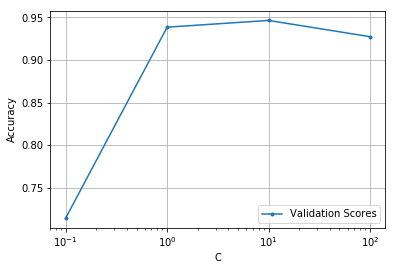

In [19]:
# and plot a figure of the train and test scores over time
plt.figure()
plt.plot(C, val_scores, label="Validation Scores", marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();
plt.show();